In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, time, math, csv
import itertools
import collections

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

#simple-maps
sys.path.append(os.path.join(os.getcwd(),"simple-maps"))
from simplemaps.SimpleFigures import simpleMap, differenceMap

# Initial setup

In [2]:
shapefile_fn = "data/intermediate/boundary_shapefiles/cb_2015_us_county_500k.shp"
shapefile_key = "GEOID"

# Load data

### Migration data

In [3]:
f = open("data/processed/county_intersection_list_2004_2014.txt")
county_list = f.read().strip().split("\n")
f.close()

county_fips_to_idx = {fips:idx for idx, fips in enumerate(county_list)}
num_counties = len(county_list)

### Per county features

In [4]:
df_medium = pd.read_csv("data/processed/affected_population_medium.csv")
df_high = pd.read_csv("data/processed/affected_population_high.csv")

In [5]:
medium_years = [2055, 2080, 2100]
high_years = [2042, 2059, 2071, 2082, 2091, 2100]

medium_total_pop = [
    df_medium["Total Population %d" % (year)].values.reshape(-1,1)
    for year in medium_years
]
medium_affected_pop = [
    df_medium["Affected Population %d" % (year)].values.reshape(-1,1)
    for year in medium_years
]
medium_unaffected_pop = [
    medium_total_pop[i] - medium_affected_pop[i]
    for i in range(len(medium_years))
]

high_total_pop = [
    df_high["Total Population %d" % (year)].values.reshape(-1,1)
    for year in high_years
]
high_affected_pop = [
    df_high["Affected Population %d" % (year)].values.reshape(-1,1)
    for year in high_years
]
high_unaffected_pop = [
    high_total_pop[i] - high_affected_pop[i]
    for i in range(len(high_years))
]

In [6]:
medium_affected_counties = [
    (affected_population > 0).reshape(-1)
    for affected_population in medium_affected_pop
]

high_affected_counties = [
    (affected_population > 0).reshape(-1)
    for affected_population in high_affected_pop
]

# DL Results

In [75]:
medium_baseline_migration = [np.load("output/dl_results/dl_medium_baseline_results_%d.npy" % (year)) for year in medium_years]
medium_affected_migration = [np.load("output/dl_results/dl_medium_affected_results_%d.npy" % (year)) for year in medium_years]
medium_ablation_migration = [np.load("output/dl_results/dl_medium_ablation_results_%d.npy" % (year)) for year in medium_years]
medium_affected_migration_flooded = [np.load("output/dl_results/dl_medium_affected_results_flooded_%d.npy" % (year)) for year in medium_years]
medium_affected_migration_unflooded = [np.load("output/dl_results/dl_medium_affected_results_unflooded_%d.npy" % (year)) for year in medium_years]


high_baseline_migration = [np.load("output/dl_results/dl_high_baseline_results_%d.npy" % (year)) for year in high_years]
high_affected_migration = [np.load("output/dl_results/dl_high_affected_results_%d.npy" % (year)) for year in high_years]
high_ablation_migration = [np.load("output/dl_results/dl_high_ablation_results_%d.npy" % (year)) for year in high_years]
high_affected_migration_flooded = [np.load("output/dl_results/dl_high_affected_results_flooded_%d.npy" % (year)) for year in high_years]
high_affected_migration_unflooded = [np.load("output/dl_results/dl_high_affected_results_unflooded_%d.npy" % (year)) for year in high_years]

model = "dl"

# ExtRad Results

In [58]:
medium_baseline_migration = [np.load("output/extrad_results/extrad_medium_baseline_results_%d.npy" % (year)) for year in medium_years]
medium_affected_migration = [np.load("output/extrad_results/extrad_medium_affected_results_%d.npy" % (year)) for year in medium_years]
medium_ablation_migration = [np.load("output/extrad_results/extrad_medium_ablation_results_%d.npy" % (year)) for year in medium_years]

high_baseline_migration = [np.load("output/extrad_results/extrad_high_baseline_results_%d.npy" % (year)) for year in high_years]
high_affected_migration = [np.load("output/extrad_results/extrad_high_affected_results_%d.npy" % (year)) for year in high_years]
high_ablation_migration = [np.load("output/extrad_results/extrad_high_ablation_results_%d.npy" % (year)) for year in high_years]

model = "extrad"

# Medium

In [76]:
for i,year in enumerate(medium_years):

    t_affected_incoming =  medium_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  medium_baseline_migration[i].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(county_list)
        if not medium_affected_counties[i][j]
    }
    map_data["46102"] = 0        

    simpleMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        outputFn="output/figures/%s_difference_both_medium_%d.tiff" % (model, year),
        noDataColor="#0000FFFF",
        cmap="Reds",
        dpi=300,
        size=(7.5,7.5/2.0),
        bounds=[22, 49, -119, -64],
        #title="Direct and Indirect Effects, Medium %d" % (year),
        colorbarRange=(1e2, 1e6),
        logScale=True,
    )

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


### Affected

In [77]:
for i,year in enumerate(medium_years):

    t_affected_incoming =  medium_affected_migration[i][medium_affected_counties[i],:].sum(axis=0)
    t_baseline_incoming =  medium_baseline_migration[i][medium_affected_counties[i],:].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(county_list)
    }
    map_data["46102"] = 0

    differenceMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        outputFn="output/figures/%s_difference_affected_medium_%d.tiff" % (model, year),
        #noDataColor="#0000FFFF",
        #cmap="Reds",
        bounds=[22, 49, -119, -64],
        #title="Difference in Incoming Migrants from Affected Areas, Medium %d" % (year),
        colorbarRange=(1e1, 1e5),
        logScale=True,
        dpi=300,
        size=(7.5,7.5/2.0)
    )

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


### Unnaffected

In [78]:
for i,year in enumerate(medium_years):

    t_affected_incoming =  medium_affected_migration[i][~medium_affected_counties[i],:].sum(axis=0)
    t_baseline_incoming =  medium_baseline_migration[i][~medium_affected_counties[i],:].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(county_list)
    }
    map_data["46102"] = 0

    differenceMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        outputFn="output/figures/%s_difference_unaffected_medium_%d.tiff" % (model, year),
        #noDataColor="#0000FFFF",
        #cmap="Reds",
        bounds=[22, 49, -119, -64],
        #title="Difference in Incoming Migrants from Unaffected Areas, Medium %d" % (year),
        colorbarRange=(1e1, 1e5),
        logScale=True,
        dpi=300,
        size=(7.5,7.5/2.0),
    )

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


### Abalation

In [79]:
for i,year in enumerate(medium_years):

    t_affected_incoming =  medium_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  medium_ablation_migration[i].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(county_list)
    }
    map_data["46102"] = 0

    differenceMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        outputFn="output/figures/%s_difference_ablation_medium_%d.tiff" % (model, year),
        #noDataColor="#0000FFFF",
        #cmap="Reds",
        bounds=[22, 49, -119, -64],
        #title="ExtRad Ablation, Medium %d" % (year),
        colorbarRange=(1e1, 1e5),
        logScale=True,
        dpi=300,
        size=(7.5,7.5/2.0),
    )

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


# High

In [80]:
for i,year in enumerate(high_years):

    t_affected_incoming =  high_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i].sum(axis=0)
    
    count = 0
    for j, county in enumerate(county_list):
        if t_affected_incoming[j] - t_baseline_incoming[j] > 0:
            count += 1
            
    print(year, count / float(len(county_list)))

2042 0.8763683193818416
2059 0.8396651641983258
2071 0.8486799742433999
2082 0.8721828718609144
2091 0.9256278171281391
2100 0.9993560849967804


In [81]:
for i,year in enumerate(high_years):

    t_affected_incoming =  high_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(county_list)
        if not high_affected_counties[i][j]
    }
    map_data["46102"] = 0

    simpleMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        outputFn="output/figures/%s_difference_both_high_%d.tiff" % (model, year),
        noDataColor="#0000FFFF",
        cmap="Reds",
        bounds=[22, 49, -119, -64],
        #title="Direct and Indirect Effects, High %d" % (year),
        colorbarRange=(1e2, 1e6),
        logScale=True,
        dpi=300,
        size=(7.5,7.5/2.0),
    )

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


### Affected

In [82]:
for i,year in enumerate(high_years):

    t_affected_incoming =  high_affected_migration[i][high_affected_counties[i],:].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i][high_affected_counties[i],:].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(county_list)
    }
    map_data["46102"] = 0

    differenceMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        outputFn="output/figures/%s_difference_affected_high_%d.tiff" % (model, year),
        #noDataColor="#0000FFFF",
        #cmap="Reds",
        bounds=[22, 49, -119, -64],
        #title="Difference in Incoming Migrants from Affected Areas, High %d" % (year),
        colorbarRange=(1e2, 1e6),
        logScale=True,
        dpi=300,
        size=(7.5,7.5/2.0),
    )

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


### Unaffected

In [83]:
for i,year in enumerate(high_years):

    t_affected_incoming =  high_affected_migration[i][~high_affected_counties[i],:].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i][~high_affected_counties[i],:].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(county_list)
    }
    map_data["46102"] = 0

    differenceMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        outputFn="output/figures/%s_difference_unaffected_high_%d.tiff" % (model, year),
        #noDataColor="#0000FFFF",
        #cmap="Reds",
        bounds=[22, 49, -119, -64],
        #title="Difference in Incoming Migrants from Unaffected Areas, High %d" % (year),
        colorbarRange=(1e2, 1e6),
        logScale=True,
        dpi=300,
        size=(7.5,7.5/2.0),
    )

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


### Ablation

In [84]:
for i,year in enumerate(high_years):

    t_affected_incoming =  high_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  high_ablation_migration[i].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(county_list)
    }
    map_data["46102"] = 0

    differenceMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        outputFn="output/figures/%s_difference_ablation_high_%d.tiff" % (model, year),
        #noDataColor="#0000FFFF",
        #cmap="Reds",
        bounds=[22, 49, -119, -64],
        #title="ExtRad Ablation, High %d" % (year),
        colorbarRange=(1e2, 1e6),
        logScale=True,
        dpi=300,
        size=(7.5,7.5/2.0),
    )

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


# Indirect Effect Thresholds

## High

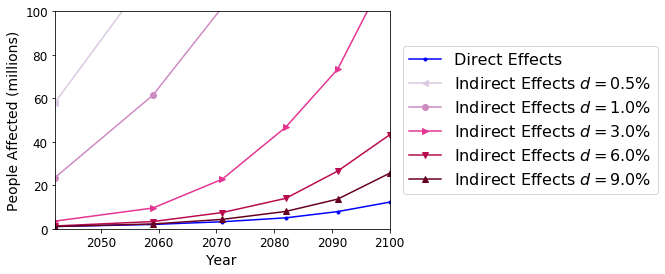

In [85]:
thresholds = [0.5, 1.0, 3.0, 6.0, 9.0]
ys_direct = []
ys_thresholds = [[] for threshold in thresholds]
divisor = 1000000.0

for i, year in enumerate(high_years):

    direct_effect = high_affected_pop[i].sum() / divisor
    ys_direct.append(direct_effect)
    
    t_affected_incoming =  high_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i].sum(axis=0)
    t_increase = t_affected_incoming - t_baseline_incoming

    for j, threshold in enumerate(thresholds):
        
        t_pop = high_total_pop[i].copy().reshape(-1)
        indirect_mask = t_increase > (t_pop * (threshold/100.0))        
        ys_thresholds[j].append(direct_effect + (t_pop[indirect_mask].sum() / divisor))
    
markers = [".", "<", "o", ">", "v", "^", "D"]
cmap = matplotlib.cm.get_cmap("PuRd")
norm = matplotlib.colors.Normalize(vmin=0,vmax=len(thresholds))
sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

width = 6
plt.figure(figsize=(width, width * (2/3)))

plt.plot(high_years, ys_direct, color="b", marker=markers[0], label="Direct Effects")

for j, threshold in enumerate(thresholds):
    plt.plot(high_years, ys_thresholds[j], color=sm.to_rgba(j+1), marker=markers[j+1], label=r"Indirect Effects $d = %0.1f \%% $" % (threshold))

plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, fontsize=16)
plt.subplots_adjust(right=0.9)

plt.xticks(fontsize=12)
plt.xlim([2042,2100])
plt.xlabel("Year", fontsize=14)

plt.yticks(fontsize=12)
plt.ylim([0,100])
plt.ylabel("People Affected (millions)", fontsize=14)

#plt.title("Direct and Indirect Effects on People", fontsize=16)
plt.savefig("output/figures/%s_direct_indirect_high_plot.tiff" % (model), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [86]:
ys_thresholds

[[57.98504873101899,
  119.242326415968,
  185.253854283103,
  243.64023083958202,
  317.968714727956,
  480.08167484969505],
 [23.508406906655,
  61.471807545685,
  101.89408565761099,
  157.332020394259,
  247.3399840592,
  357.440394752602],
 [3.527707076347,
  9.560828281151998,
  22.79631643383,
  46.740459938312995,
  73.414316674302,
  120.066989501932],
 [1.2945761638520001,
  3.330225585905,
  7.464871268254999,
  13.992133438726999,
  26.547473988693,
  43.226950714393],
 [1.0533262140970001,
  2.223931535618,
  4.326714478144,
  7.981549012678,
  13.647237540972998,
  25.551806224639]]

In [87]:
thresholds = [0.5, 1.0, 3.0, 6.0, 9.0]
labels = [
    "Directly\nAffected"
] + [">%0.1f%%" % (threshold) for threshold in thresholds] + ["Not\nAffected"]

cmap = matplotlib.colors.ListedColormap(
    ["#0000FFFF"] + [sm.to_rgba(j+1) for j in range(len(thresholds))] + ["#FFFFFFFF"],
    N = len(labels)
)
hackMapping = {
    i:i for i in range(len(labels))
}

for i, year in enumerate(high_years):
    
    direct_effect = high_affected_pop[i].sum() / divisor
    ys_direct.append(direct_effect)
    
    t_affected_incoming =  high_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i].sum(axis=0)
    t_increase = t_affected_incoming - t_baseline_incoming
    
    t_map = (high_affected_pop[i] > 0).reshape(-1).astype(int)
    t_mask = (high_affected_pop[i] > 0).reshape(-1)

    for j, threshold in enumerate(thresholds):
        
        t_pop = high_total_pop[i].copy().reshape(-1)
        indirect_mask = t_increase > (t_pop * (threshold/100.0))
        t_map[indirect_mask] = j+2
    
    t_map[t_map==0] = len(thresholds) + 2
    t_map -= 1
    t_map[t_mask] = 0
    print(np.unique(t_map, return_counts=True))
 
    map_data = {
        county: t_map[j]
        for j, county in enumerate(county_list)
    }
    map_data["46102"] = 6

    
    simpleMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        cmap=cmap,
        outputFn="output/figures/%s_direct_indirect_high_%d.tiff" % (model, year),
        colorbarType=1,
        colorbarLabels=labels,
        dataToColorIdxMap=hackMapping,
        bounds=[22, 49, -119, -64],
        #title="Direct and Indirect Effects at different thresholds, High %d" % (year),
        dpi=300,
        size=(7.5,7.5/2.0),
    )

(array([0, 1, 2, 3, 6]), array([ 336,   35,   30,    4, 2701]))


/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


(array([0, 1, 2, 3, 4, 5, 6]), array([ 340,   51,   49,   19,    4,    1, 2642]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 341,   68,   76,   25,    8,    7, 2581]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 345,   82,  108,   39,   15,    9, 2508]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 346,   84,  185,   83,   22,   20, 2366]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 349,  448, 1092,  520,  185,  194,  318]))


## Medium

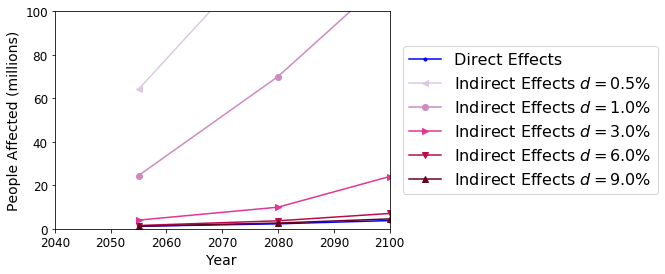

In [88]:
thresholds = [0.5, 1.0, 3.0, 6.0, 9.0]
ys_direct = []
ys_thresholds = [[] for threshold in thresholds]
divisor = 1000000.0

for i, year in enumerate(medium_years):

    direct_effect = medium_affected_pop[i].sum() / divisor
    ys_direct.append(direct_effect)
    
    t_affected_incoming =  medium_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  medium_baseline_migration[i].sum(axis=0)
    t_increase = t_affected_incoming - t_baseline_incoming

    for j, threshold in enumerate(thresholds):
        
        t_pop = medium_total_pop[i].copy().reshape(-1)
        indirect_mask = t_increase > (t_pop * (threshold/100.0))        
        ys_thresholds[j].append(direct_effect + (t_pop[indirect_mask].sum() / divisor))
    
markers = [".", "<", "o", ">", "v", "^", "D"]
cmap = matplotlib.cm.get_cmap("PuRd")
norm = matplotlib.colors.Normalize(vmin=0,vmax=len(thresholds))
sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    
width = 6
plt.figure(figsize=(width, width * (2/3)))

plt.plot(medium_years, ys_direct, color="b", marker=markers[0], label="Direct Effects")

for j, threshold in enumerate(thresholds):
    plt.plot(medium_years, ys_thresholds[j], color=sm.to_rgba(j+1), marker=markers[j+1], label=r"Indirect Effects $d = %0.1f \%% $" % (threshold))

plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, fontsize=16)
plt.subplots_adjust(right=0.9)

plt.xticks(fontsize=12)
plt.xlim([2040,2100])
plt.xlabel("Year", fontsize=14)

plt.yticks(fontsize=12)
plt.ylim([0,100])
plt.ylabel("People Affected (millions)", fontsize=14)

#plt.title("Direct and Indirect Effects on People", fontsize=16)
plt.savefig("output/figures/%s_direct_indirect_medium_plot.tiff" % (model), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [89]:
ys_thresholds

[[64.19966678003, 133.99297666985802, 218.44486347618403],
 [24.480613339767, 70.029473922889, 116.309944326826],
 [3.991097393712, 9.941186907226, 24.044542192111003],
 [1.510507927696, 3.6791265719219997, 7.056902167376],
 [1.174471006741, 2.651592444072, 4.548951707133]]

In [90]:
thresholds = [0.5, 1.0, 3.0, 6.0, 9.0]
labels = [
    "Directly\nAffected"
] + [">%0.1f%%" % (threshold) for threshold in thresholds] + ["Not\nAffected"]

cmap = matplotlib.colors.ListedColormap(
    ["#0000FFFF"] + [sm.to_rgba(j+1) for j in range(len(thresholds))] + ["#FFFFFFFF"],
    N = len(labels)
)
hackMapping = {
    i:i for i in range(len(labels))
}

for i, year in enumerate(medium_years):
    
    direct_effect = medium_affected_pop[i].sum() / divisor
    ys_direct.append(direct_effect)
    
    t_affected_incoming =  medium_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  medium_baseline_migration[i].sum(axis=0)
    t_increase = t_affected_incoming - t_baseline_incoming
    
    t_map = (medium_affected_pop[i] > 0).reshape(-1).astype(int)
    t_mask = (medium_affected_pop[i] > 0).reshape(-1)

    for j, threshold in enumerate(thresholds):
        
        t_pop = medium_total_pop[i].copy().reshape(-1)
        indirect_mask = t_increase > (t_pop * (threshold/100.0))
        t_map[indirect_mask] = j+2
    
    t_map[t_map==0] = len(thresholds) + 2
    t_map -= 1
    t_map[t_mask] = 0
    print(np.unique(t_map, return_counts=True))
 
    map_data = {
        county: t_map[j]
        for j, county in enumerate(county_list)
    }
    map_data["46102"] = 6

    
    simpleMap(
        shapefile_fn,
        shapefile_key,
        map_data,
        cmap=cmap,
        outputFn="output/figures/%s_direct_indirect_medium_%d.tiff" % (model, year),
        colorbarType=1,
        colorbarLabels=labels,
        dataToColorIdxMap=hackMapping,
        bounds=[22, 49, -119, -64],
        #title="Direct and Indirect Effects at different thresholds, Medium %d" % (year),
        dpi=300,
        size=(7.5,7.5/2.0),
    )

(array([0, 1, 2, 3, 6]), array([ 336,   33,   33,    6, 2698]))


/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


(array([0, 1, 2, 3, 4, 5, 6]), array([ 340,   56,   53,   20,    4,    2, 2631]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 341,   77,   81,   28,   11,    5, 2563]))
